# **📚 Huấn luyện Mô hình VGG11**

## **🎯 Mục tiêu**
- Xây dựng và huấn luyện **mô hình VGG11** để **phân loại ảnh** trong tập dữ liệu **CIFAR-100**.
- Thực hiện các bước cơ bản:
  - **Tiền xử lý dữ liệu**.
  - **Tăng cường dữ liệu** (*Data Augmentation*).
  - **Phân chia dữ liệu** thành các tập: Huấn luyện, Validation, và Kiểm tra.
- Đánh giá mô hình qua các chỉ số quan trọng:
  - **Loss** (*Hàm mất mát*).
  - **Accuracy** (*Độ chính xác*).
  - **Thời gian huấn luyện**.
- Phân tích kết quả thông qua các biểu đồ trực quan:
  - Biểu đồ **Loss** và **Accuracy**.
  - **Confusion Matrix** (*Ma trận nhầm lẫn*).

## **🚀 Yêu cầu trước khi bắt đầu**

> **Cấu hình Google Colab với GPU**
- Truy cập vào menu **Runtime** (Thời gian chạy).
- Chọn **Change runtime type** (Thay đổi kiểu môi trường).
- Trong mục **Hardware accelerator** (Trình tăng tốc phần cứng), chọn: **T4 GPU**.
- Nhấn nút **Save** (Lưu) để lưu thay đổi.

## **⚡ Chạy đoạn mã dưới đây để thực hiện:**



In [ ]:
# 0.1. Import thư viện PyTorch để kiểm tra GPU
import torch

# 0.2. Xác định thiết bị (device) đang sử dụng: "cuda" (GPU) nếu khả dụng, ngược lại là "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0.3. Kiểm tra nếu thiết bị là GPU
if device.type == 'cuda':
    # 0.3.1. Lấy tên GPU đang được sử dụng
    gpu_name = torch.cuda.get_device_name(0)
    # 0.3.2. Lấy tổng dung lượng bộ nhớ GPU (VRAM) và chuyển đổi sang đơn vị GB
    vram_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    # 0.3.3. Hiển thị thông tin về GPU
    print(f"✅ Đang sử dụng GPU: {gpu_name}")
    print(f"🔹 Tổng bộ nhớ GPU (VRAM): {vram_total:.2f} GB")
else:
    # 0.3.4. Nếu không có GPU, thông báo sử dụng CPU và yêu cầu bật GPU trong Google Colab
    print("❌ Đang sử dụng CPU. Vui lòng bật GPU trong Google Colab!")

✅ Đang sử dụng GPU: Tesla T4
🔹 Tổng bộ nhớ GPU (VRAM): 14.75 GB


# **1. Chuẩn bị môi trường**

> Để chuẩn bị cho việc xây dựng và huấn luyện mô hình, cần thực hiện các bước sau:
> - Nạp các thư viện cần thiết để xử lý dữ liệu và xây dựng mô hình.
> - Kết nối Google Drive (nếu dữ liệu được lưu trên Drive).
> - Xác định đường dẫn đến các tệp dữ liệu và tải chúng vào chương trình.
> - Khám phá dữ liệu để hiểu rõ cấu trúc và nội dung trước khi huấn luyện.


## **1.1. Import thư viện cần thiết**

In [ ]:
# Import thư viện cơ bản
from google.colab import drive                                                   # Liên kết Google Drive
import torch                                                                     # Thư viện PyTorch
import numpy as np                                                               # Xử lý mảng
import pickle                                                                    # Đọc/ghi file dữ liệu nhị phân
import os                                                                        # Thao tác với hệ thống tệp
import urllib.request
import tarfile

# Import thư viện xử lý và tăng cường dữ liệu
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Import các module cho mô hình học sâu
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast

# Các thư viện hỗ trợ khác
import time                                                                      # Đo thời gian
import json                                                                      # Lưu trữ dữ liệu
import matplotlib.pyplot as plt                                                  # Vẽ biểu đồ
import pandas as pd                                                              # Xử lý dữ liệu dạng bảng
import random                                                                    # Xử lý ngẫu nhiên
from collections import Counter                                                  # Đếm tần suất
from ipywidgets import interact, widgets                                         # 1.3.8.
import matplotlib.pyplot as plt                                                  # 1.3.8.
import base64                                                                    # 1.7.
from io import BytesIO                                                           # 1.7.
from PIL import Image

# Mục 8.
import matplotlib.pyplot as plt                                                  # Thư viện vẽ biểu đồ cơ bản
import seaborn as sns                                                            # Thư viện vẽ biểu đồ nâng cao
import numpy as np                                                               # Xử lý mảng số học
import pandas as pd                                                              # Xử lý dữ liệu dạng bảng
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay             # Đánh giá hiệu suất

## **1.2. Liên kết Google Drive**

> Liên kết Google Drive để truy cập và sử dụng các tập dữ liệu đã được lưu trữ.

In [ ]:
# 1.2. Liên kết Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **1.3. Tải và thiết lập CIFAR-100**

> Khai báo đường dẫn đến các tập dữ liệu huấn luyện và tập kiểm tra được lưu trữ trong Google Drive.

In [ ]:
# 1.3.1. Tải và thiết lập đường dẫn đến tập dữ liệu
# Đường dẫn URL chứa dữ liệu CIFAR-100
CIFAR100_URL = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

# Đường dẫn thư mục lưu trữ dữ liệu
DATA_PATH = '/content/drive/MyDrive/'

def download_and_extract_cifar100(data_path, url):
    """
    Hàm tải và giải nén dữ liệu CIFAR-100.
    """
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Đường dẫn file nén
    tar_path = os.path.join(data_path, "cifar-100-python.tar.gz")

    # Tải file nếu chưa tồn tại
    if not os.path.exists(tar_path):
        print("Đang tải dữ liệu CIFAR-100...")
        urllib.request.urlretrieve(url, tar_path)
        print("Tải thành công.")
    else:
        print("File dữ liệu đã tồn tại, bỏ qua bước tải.")

    # Giải nén file
    print("Đang giải nén dữ liệu...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=data_path)
    print("Giải nén thành công.")

    # Xác minh kết quả
    extracted_path = os.path.join(data_path, 'cifar-100-python')
    if os.path.exists(extracted_path):
        print(f"Dữ liệu đã được giải nén tại: {extracted_path}")
    else:
        print("Có lỗi trong quá trình giải nén.")

# Gọi hàm để tải và giải nén dữ liệu
download_and_extract_cifar100(DATA_PATH, CIFAR100_URL)

# Đường dẫn sau khi giải nén
TRAIN_PATH = os.path.join(DATA_PATH, 'cifar-100-python', 'train')  # Đường dẫn tập train
TEST_PATH = os.path.join(DATA_PATH, 'cifar-100-python', 'test')    # Đường dẫn tập test
META_PATH = os.path.join(DATA_PATH, 'cifar-100-python', 'meta')    # Đường dẫn meta
meta_path = os.path.join(DATA_PATH, 'cifar-100-python', 'meta')

print(f"Đường dẫn đến tập huấn luyện: {TRAIN_PATH}")
print(f"Đường dẫn đến tập kiểm tra: {TEST_PATH}")
print(f"Đường dẫn đến meta: {META_PATH}")

File dữ liệu đã tồn tại, bỏ qua bước tải.
Đang giải nén dữ liệu...
Giải nén thành công.
Dữ liệu đã được giải nén tại: /content/drive/MyDrive/cifar-100-python
Đường dẫn đến tập huấn luyện: /content/drive/MyDrive/cifar-100-python/train
Đường dẫn đến tập kiểm tra: /content/drive/MyDrive/cifar-100-python/test
Đường dẫn đến meta: /content/drive/MyDrive/cifar-100-python/meta


In [ ]:
# 1.3.2. Liệt kê các tệp trong thư mục dữ liệu
# Đường dẫn đến thư mục dữ liệu sau khi giải nén
DATA_PATH = '/content/drive/MyDrive/cifar-100-python/'

# Liệt kê các file trong thư mục
train_files = os.listdir(DATA_PATH)
print(f"Các tệp trong thư mục dữ liệu: {train_files}")

Các tệp trong thư mục dữ liệu: ['file.txt~', 'train', 'meta', 'test']


In [ ]:
# 1.3.3. Tải dữ liệu huấn luyện, kiểm tra và meta từ các tệp pickle
with open(os.path.join(DATA_PATH, 'train'), 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')                                # Tải dữ liệu huấn luyện từ tệp 'train'
with open(os.path.join(DATA_PATH, 'test'), 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')                                 # Tải dữ liệu kiểm tra từ tệp 'test'
with open(os.path.join(DATA_PATH, 'meta'), 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')                                 # Tải dữ liệu thông tin lớp từ tệp 'meta'
with open(meta_path, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')                                 # Tải lại dữ liệu meta, phục vụ cho mục 7

Tổng số ảnh trong tập dữ liệu: 60000
Tổng số ảnh trong tập huấn luyện: 50000 (83.33%)
Tổng số ảnh trong tập kiểm tra: 10000 (16.67%)



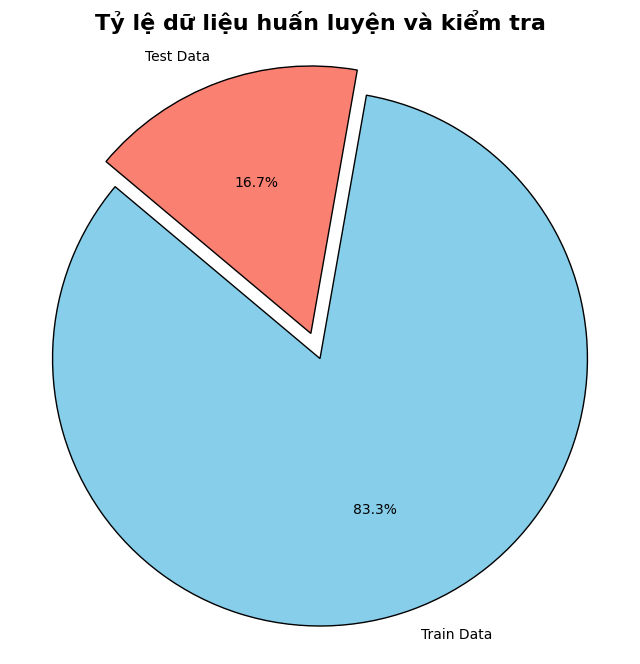

In [ ]:
# 1.3.4. Hiển thị thông tin về số lượng ảnh (cải tiến)

# 1.3.4.1. Tính toán số lượng ảnh
num_train_images = len(train_data[b'data'])                                                   # Tổng số ảnh trong tập huấn luyện
num_test_images = len(test_data[b'data'])                                                     # Tổng số ảnh trong tập kiểm tra
total_images = num_train_images + num_test_images                                             # Tổng số ảnh

# 1.3.4.2. Tính tỷ lệ phần trăm
train_percentage = (num_train_images / total_images) * 100                                    # Tỷ lệ dữ liệu huấn luyện
test_percentage = (num_test_images / total_images) * 100                                      # Tỷ lệ dữ liệu kiểm tra

# 1.3.4.3. In thông tin chi tiết
print(f"Tổng số ảnh trong tập dữ liệu: {total_images}")
print(f"Tổng số ảnh trong tập huấn luyện: {num_train_images} ({train_percentage:.2f}%)")
print(f"Tổng số ảnh trong tập kiểm tra: {num_test_images} ({test_percentage:.2f}%)\n")

# 1.3.4.4. Hiển thị tỷ lệ bằng biểu đồ tròn
labels = ['Train Data', 'Test Data']
sizes = [num_train_images, num_test_images]
colors = ['skyblue', 'salmon']
explode = (0.1, 0)                                                                            # Nổi bật phần Train Data

plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode,
    wedgeprops={'edgecolor': 'black'}                                                         # Viền đen để nổi bật
)
plt.title("Tỷ lệ dữ liệu huấn luyện và kiểm tra", fontsize=16, fontweight='bold')
plt.axis('equal')                                                                             # Đảm bảo biểu đồ hình tròn cân đối
plt.show()

In [ ]:
# 1.3.5. Đọc thông tin tên các lớp và phân loại chính từ tệp meta (tăng khoảng cách giữa các cột)

# 1.3.5.2. Lấy danh sách các loại con và loại lớn từ dữ liệu meta
fine_classes = meta_data[b'fine_label_names']                                                               # Danh sách tên loại con (fine classes)
coarse_classes = meta_data[b'coarse_label_names']                                                           # Danh sách tên loại lớn (coarse classes)

# 1.3.5.3. In tổng số loại lớn và loại con
total_fine_classes = len(fine_classes)                                                                      # Tổng số loại con
total_coarse_classes = len(coarse_classes)                                                                  # Tổng số loại lớn

print(f"Tổng số loại con (fine classes) trong tập dữ liệu: {total_fine_classes}")
print(f"Tổng số loại lớn (coarse classes) trong tập dữ liệu: {total_coarse_classes}\n")

# 1.3.5.4. Hiển thị danh sách các loại lớn (coarse classes) theo dạng bảng (tăng khoảng cách)
print("Danh sách các loại lớp lớn (coarse classes):")
num_columns_coarse = 4                                                                                      # Số cột hiển thị cho loại lớn
rows_coarse = total_coarse_classes // num_columns_coarse + (total_coarse_classes % num_columns_coarse > 0)  # Tính số dòng

formatted_coarse_table = []                                                                                 # Danh sách lưu bảng đã định dạng
for i in range(rows_coarse):
    row = []
    for j in range(num_columns_coarse):
        idx = i + j * rows_coarse
        if idx < total_coarse_classes:
            row.append(f"{idx:2}: {coarse_classes[idx].decode('utf-8'):<40}")                               # Format tên lớp (độ rộng cố định 45 ký tự)
        else:
            row.append("")                                                                                  # Thêm ô trống nếu không đủ dữ liệu
    formatted_coarse_table.append(row)

# In danh sách các loại lớn theo từng dòng
for row in formatted_coarse_table:
    print("".join(row))                                                                                     # In từng dòng với khoảng cách đồng đều

# 1.3.5.5. Hiển thị danh sách các loại con (fine classes) theo dạng bảng
print("\nDanh sách các loại lớp con (fine classes):")
num_columns_fine = 4                                                                                        # Số cột hiển thị cho loại con
rows_fine = total_fine_classes // num_columns_fine + (total_fine_classes % num_columns_fine > 0)            # Tính số dòng

formatted_fine_table = []                                                                                   # Danh sách lưu bảng đã định dạng
for i in range(rows_fine):
    row = []
    for j in range(num_columns_fine):
        idx = i + j * rows_fine
        if idx < total_fine_classes:
            row.append(f"{idx:2}: {fine_classes[idx].decode('utf-8'):<25}")                                 # Format tên lớp (độ rộng cố định 25 ký tự)
        else:
            row.append("")                                                                                  # Thêm ô trống nếu không đủ dữ liệu
    formatted_fine_table.append(row)

# In danh sách các loại con theo từng dòng
for row in formatted_fine_table:
    print("".join(row))                                                                                     # In từng dòng với khoảng cách đồng đều

Tổng số loại con (fine classes) trong tập dữ liệu: 100
Tổng số loại lớn (coarse classes) trong tập dữ liệu: 20

Danh sách các loại lớp lớn (coarse classes):
 0: aquatic_mammals                          5: household_electrical_devices            10: large_natural_outdoor_scenes            15: reptiles                                
 1: fish                                     6: household_furniture                     11: large_omnivores_and_herbivores          16: small_mammals                           
 2: flowers                                  7: insects                                 12: medium_mammals                          17: trees                                   
 3: food_containers                          8: large_carnivores                        13: non-insect_invertebrates                18: vehicles_1                              
 4: fruit_and_vegetables                     9: large_man-made_outdoor_things           14: people                                  19:

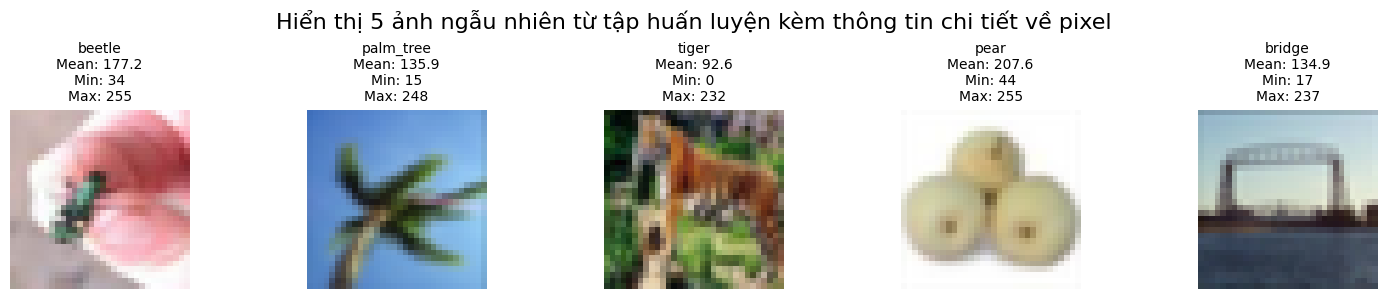

In [ ]:
# 1.3.6. Hiển thị ngẫu nhiên các ảnh từ tập huấn luyện (có thông tin pixel)

class_names = meta_data[b'fine_label_names']                                                                    # Load danh sách tên lớp con (fine classes)

# 1.3.6.1. Thiết lập hiển thị 5 ảnh ngẫu nhiên
fig, axes = plt.subplots(1, 5, figsize=(15, 3))                                                                 # Tạo khung hiển thị với 5 cột
for i in range(5):
    # 1.3.6.2. Chọn ngẫu nhiên một ảnh từ tập huấn luyện
    random_idx = random.randint(0, num_train_images - 1)                                                        # Chỉ số ngẫu nhiên
    image = train_data[b'data'][random_idx].reshape(3, 32, 32).transpose(1, 2, 0)                               # Chuyển đổi định dạng ảnh
    label = train_data[b'fine_labels'][random_idx]                                                              # Lấy nhãn tương ứng

    # 1.3.6.3. Tính thông tin pixel
    mean_pixel = image.mean()                                                                                   # Giá trị pixel trung bình
    min_pixel = image.min()                                                                                     # Giá trị pixel nhỏ nhất
    max_pixel = image.max()                                                                                     # Giá trị pixel lớn nhất

    # 1.3.6.4. Hiển thị ảnh và nhãn
    axes[i].imshow(image)                                                                                       # Hiển thị ảnh
    axes[i].axis('off')                                                                                         # Tắt khung viền xung quanh
    axes[i].set_title(
        f"{class_names[label].decode('utf-8')}\nMean: {mean_pixel:.1f}\nMin: {min_pixel}\nMax: {max_pixel}",
        fontsize=10                                                                                             # Đặt tiêu đề với thông tin pixel
    )

# 1.3.6.5. Đặt tiêu đề chung cho toàn bộ biểu đồ
plt.suptitle("Hiển thị 5 ảnh ngẫu nhiên từ tập huấn luyện kèm thông tin chi tiết về pixel", fontsize=16)
plt.tight_layout()                                                                                              # Điều chỉnh khoảng cách giữa các ảnh
plt.show()

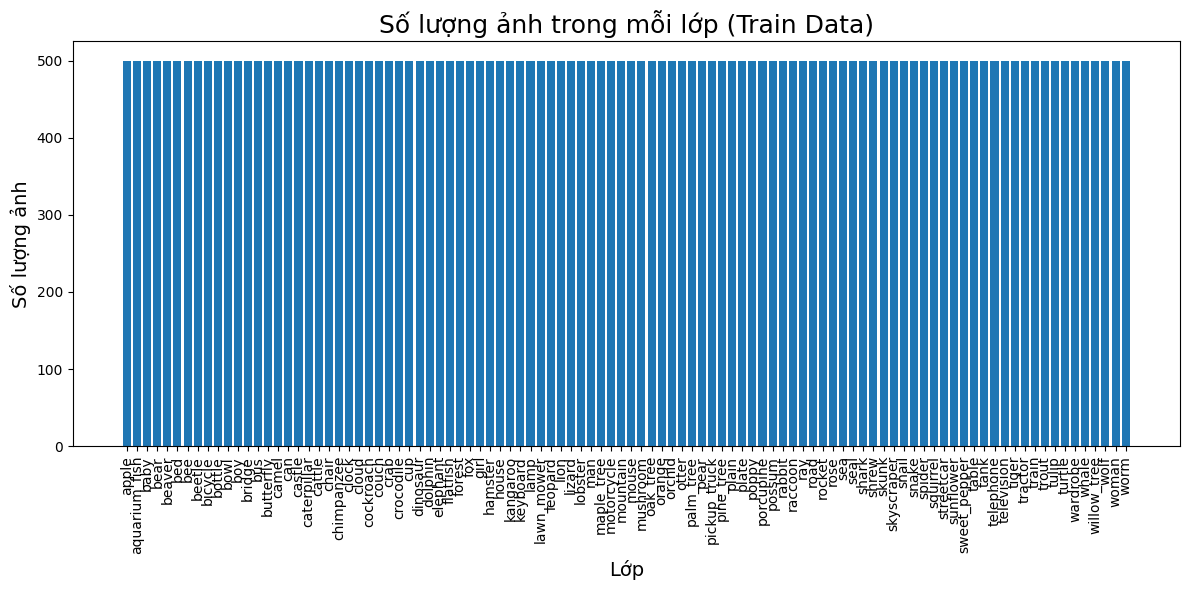

In [ ]:
# 1.3.7. Biểu đồ số lượng ảnh trong mỗi lớp

# 1.3.7.1. Đếm số lượng ảnh theo từng lớp
labels = train_data[b'fine_labels']                                              # Lấy danh sách các nhãn trong tập huấn luyện
label_counts = Counter(labels)                                                   # Đếm tần suất xuất hiện của từng nhãn

# 1.3.7.2. Vẽ biểu đồ cột thể hiện số lượng ảnh trong từng lớp
plt.figure(figsize=(12, 6))                                                      # Kích thước biểu đồ
plt.bar(label_counts.keys(), label_counts.values())                              # Tạo biểu đồ cột
plt.xlabel('Lớp', fontsize=14)                                                   # Nhãn trục X
plt.ylabel('Số lượng ảnh', fontsize=14)                                          # Nhãn trục Y
plt.title('Số lượng ảnh trong mỗi lớp (Train Data)', fontsize=18)                # Tiêu đề biểu đồ

# 1.3.7.3. Tùy chỉnh nhãn trục X
plt.xticks(
    ticks=list(label_counts.keys()),
    labels=[class_names[i].decode('utf-8') for i in label_counts.keys()],
    rotation=90                                                                  # Xoay nhãn trục X 90 độ
)

# 1.3.7.4. Căn chỉnh và hiển thị biểu đồ
plt.tight_layout()                                                               # Căn chỉnh biểu đồ để không bị tràn khung
plt.show()

In [ ]:
# 1.3.8. Hiển thị ảnh theo lựa chọn của người dùng (thêm khoảng cách)

class_names = meta_data[b'fine_label_names']                                                             # Load danh sách tên lớp con (fine classes)

# 1.3.8.1. Thêm mô tả phía trên menu
print("Chọn một lớp từ danh sách bên dưới để xem 5 ảnh ngẫu nhiên thuộc lớp đó:")

# 1.3.8.2. Hàm hiển thị ảnh của một lớp được chọn
def show_images_for_class(class_name):
    # Tìm chỉ số của lớp được chọn
    class_idx = [i for i, name in enumerate(class_names) if name.decode('utf-8') == class_name][0]

    # Lấy tất cả ảnh thuộc lớp này
    class_images = [train_data[b'data'][idx].reshape(3, 32, 32).transpose(1, 2, 0)
                    for idx, label in enumerate(train_data[b'fine_labels']) if label == class_idx]

    # Hiển thị 5 ảnh ngẫu nhiên từ lớp
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    plt.subplots_adjust(top=0.8)                                                                         # Thêm khoảng cách phía trên giữa dropdown và ảnh
    for i in range(5):
        axes[i].imshow(class_images[i])                                                                  # Hiển thị ảnh
        axes[i].axis('off')                                                                              # Tắt viền
        axes[i].set_title(class_name, fontsize=10)                                                       # Tên lớp

    # Tiêu đề chung
    plt.suptitle(f"5 ảnh ngẫu nhiên từ lớp: {class_name}", fontsize=16)
    plt.show()

# 1.3.8.3. Dropdown menu để chọn lớp
class_dropdown = widgets.Dropdown(
    options=[name.decode('utf-8') for name in class_names],
    description='Lớp:',
    style={'description_width': 'initial'}
)

# 1.3.8.4. Tích hợp dropdown với hàm hiển thị ảnh
interact(show_images_for_class, class_name=class_dropdown)

In [ ]:
# 1.3.9. Hiển thị số lượng ảnh của từng lớp bằng giao diện tương tác

# 1.3.9.1. Hàm hiển thị số lượng ảnh cho một lớp cụ thể
def show_class_image_count(class_name):
    # Tìm chỉ số của lớp được chọn
    class_idx = [i for i, name in enumerate(class_names) if name.decode('utf-8') == class_name][0]

    # Đếm số lượng ảnh thuộc lớp đó
    count = sum(1 for label in train_data[b'fine_labels'] if label == class_idx)
    print(f"Số lượng ảnh trong lớp '{class_name}': {count}")

# 1.3.9.2. Dropdown menu để chọn lớp
class_dropdown = widgets.Dropdown(
    options=[name.decode('utf-8') for name in class_names],
    description='Chọn lớp:',
    style={'description_width': 'initial'}
)

# 1.3.9.3. Tích hợp với giao diện tương tác
interact(show_class_image_count, class_name=class_dropdown)

interactive(children=(Dropdown(description='Chọn lớp:', options=('apple', 'aquarium_fish', 'baby', 'bear', 'be…

<function __main__.show_class_image_count(class_name)>

In [ ]:
# 1.3.10. Giao diện tương tác để vẽ biểu đồ phân bố giá trị pixel

# 1.3.10.1. Thêm mô tả phía trên menu
print("Chọn một lớp từ danh sách bên dưới để xem 5 ảnh ngẫu nhiên thuộc lớp đó:")

# 1.3.10.2. Hàm vẽ biểu đồ phân bố giá trị pixel của một lớp
def plot_pixel_distribution(class_name):
    # Tìm chỉ số của lớp được chọn
    class_idx = [i for i, name in enumerate(class_names) if name.decode('utf-8') == class_name][0]

    # Lấy tất cả ảnh thuộc lớp được chọn
    class_images = [train_data[b'data'][idx] for idx, label in enumerate(train_data[b'fine_labels']) if label == class_idx]
    pixel_values = np.concatenate(class_images).flatten()  # Kết hợp tất cả ảnh và làm phẳng

    # Vẽ biểu đồ phân bố
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Giá trị pixel', fontsize=14)
    plt.ylabel('Tần suất', fontsize=14)
    plt.title(f'Phân bố giá trị pixel của lớp: {class_name}', fontsize=16, fontweight='bold')
    plt.show()

# 1.3.10.3. Dropdown menu để chọn lớp
class_dropdown = widgets.Dropdown(
    options=[name.decode('utf-8') for name in class_names],
    description='Chọn lớp:',
    style={'description_width': 'initial'}
)

# 1.3.10.4. Tích hợp với giao diện tương tác
interact(plot_pixel_distribution, class_name=class_dropdown)

Chọn một lớp từ danh sách bên dưới để xem 5 ảnh ngẫu nhiên thuộc lớp đó:


interactive(children=(Dropdown(description='Chọn lớp:', options=('apple', 'aquarium_fish', 'baby', 'bear', 'be…

<function __main__.plot_pixel_distribution(class_name)>

## **1.4. Tạo lớp Dataset tùy chỉnh**
- Để xử lý dữ liệu CIFAR-100 hiệu quả hơn, cần xây dựng một lớp Dataset tùy chỉnh.  
> Lớp này sẽ giúp:
  - Quản lý dữ liệu ảnh và nhãn tương ứng.
  - Tạo điều kiện thuận lợi cho việc sử dụng trong DataLoader để huấn luyện mô hình.

- Ví dụ dễ hiểu hơn, lớp này giống như **người quản lý**, giúp chia dữ liệu thành từng **ảnh và nhãn** để mô hình học được.

In [ ]:
# 1.4. Xây dựng lớp Dataset cho CIFAR-100

# 1.4.1. Định nghĩa lớp Dataset cho CIFAR-100
class CIFAR100Dataset(Dataset):
    # 1.4.2. Khởi tạo lớp với các tham số: dữ liệu, nhãn và hàm xử lý ảnh (nếu có)
    def __init__(self, data, labels, transform=None):
        self.data = data                                                                                  # Lưu trữ dữ liệu ảnh
        self.labels = labels                                                                              # Lưu trữ nhãn tương ứng với từng ảnh
        self.transform = transform                                                                        # Lưu trữ hàm xử lý ảnh (nếu có)

    # 1.4.3. Trả về tổng số mẫu trong tập dữ liệu
    def __len__(self):
        return len(self.data)                                                                             # Trả về số lượng mẫu trong dữ liệu

    # 1.4.4. Trả về một ảnh và nhãn tương ứng tại vị trí idx
    def __getitem__(self, idx):
        # 1.4.5. Lấy ảnh tại chỉ số idx và chuyển đổi thành định dạng (3, 32, 32) để phù hợp với PyTorch
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)                                      # Chuyển ảnh từ định dạng (32, 32, 3) thành (3, 32, 32)

        # 1.4.6. Lấy nhãn của ảnh tại chỉ số idx
        label = self.labels[idx]                                                                          # Nhãn tương ứng với ảnh

        # 1.4.7. Nếu có hàm xử lý ảnh (transform), áp dụng lên ảnh
        if self.transform:
            image = self.transform(image)                                                                 # Áp dụng biến đổi (như chuẩn hóa, xoay ảnh, v.v.)

        # 1.4.8. Trả về ảnh và nhãn (ảnh được chuyển thành Tensor)
        return image, label                                                                               # Trả về ảnh và nhãn, ảnh có thể đã được xử lý

## **1.5. Tiền xử lý dữ liệu**

Trước khi huấn luyện mô hình, cần tải dữ liệu và xử lý để đảm bảo mô hình hoạt động tốt hơn.  
> Các bước thực hiện:
  - **Tải dữ liệu**: Lấy dữ liệu từ các tệp `pickle` của tập CIFAR-100.
  - **Tăng cường dữ liệu**: Áp dụng các kỹ thuật như lật ảnh, cắt ảnh để làm phong phú tập huấn luyện.
  - **Chuẩn hóa dữ liệu**: Chuyển giá trị pixel về khoảng [-1, 1] để cải thiện quá trình học của mô hình.


In [ ]:
# 1.5.1. Tải dữ liệu từ tệp pickle
with open(TRAIN_PATH, 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')                                # Tải tập dữ liệu huấn luyện từ tệp pickle
with open(TEST_PATH, 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')                                 # Tải tập dữ liệu kiểm tra từ tệp pickle

# 1.5.2. Tăng cường dữ liệu cho tập huấn luyện
train_transform = transforms.Compose([
    transforms.ToPILImage(),                                                     # Chuyển ảnh từ dạng số sang ảnh PIL (hỗ trợ xử lý ảnh dễ dàng hơn)
    transforms.Resize((32, 32)),                                                 # Thay đổi kích thước ảnh về 32x32 (đảm bảo đồng nhất kích thước)
    transforms.RandomHorizontalFlip(),                                           # Lật ngang ảnh ngẫu nhiên để tăng cường dữ liệu
    transforms.RandomCrop(32, padding=4),                                        # Cắt ảnh ngẫu nhiên với viền đệm 4 pixel
    transforms.ToTensor(),                                                       # Chuyển ảnh từ PIL sang Tensor (định dạng PyTorch yêu cầu)
    transforms.Normalize((0.5, 0.5, 0.5),                                        # Chuẩn hóa giá trị pixel (mean cho từng kênh RGB)
                         (0.5, 0.5, 0.5))                                        # Chuẩn hóa giá trị pixel (std cho từng kênh RGB)
])

# 1.5.3. Xử lý dữ liệu kiểm tra
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                                     # Chuyển ảnh từ dạng số sang ảnh PIL
    transforms.Resize((32, 32)),                                                 # Thay đổi kích thước ảnh về 32x32
    transforms.ToTensor(),                                                       # Chuyển ảnh từ PIL sang Tensor
    transforms.Normalize((0.5, 0.5, 0.5),                                        # Chuẩn hóa giá trị pixel (mean cho từng kênh RGB)
                         (0.5, 0.5, 0.5))                                        # Chuẩn hóa giá trị pixel (std cho từng kênh RGB)
])

## **1.6. Khởi tạo DataLoader**

#### **Thiết lập thông số:**

1. **Chia tập dữ liệu:**
   > - **Tập huấn luyện (train):** Chiếm 90% dữ liệu.
   - **Tập kiểm tra (validation):** Chiếm 10% dữ liệu.

2. **Sử dụng DataLoader:**
   > - **Tập huấn luyện:** Xáo trộn dữ liệu để tăng tính ngẫu nhiên, giúp cải thiện khả năng tổng quát hóa của mô hình.
   - **Tập kiểm tra và validation:** Dữ liệu giữ nguyên thứ tự để đảm bảo tính nhất quán trong đánh giá mô hình.

#### **Công thức tính số batch**

Số batch trong mỗi tập dữ liệu được tính như sau:
$$
\text{Số batch} = \frac{\text{Tổng số mẫu}}{\text{Batch size}}
$$


#### **Ví dụ tính toán:**

- **Tập huấn luyện:**
$$
\text{Số batch (train)} = \frac{45000}{128} = 351.5625 = 352
$$

- **Tập kiểm tra:**
$$
\text{Số batch (validation)} = \frac{5000}{128}  =  39.0625 = 40
$$


#### **Kết quả:**
- Tập huấn luyện: **352** batch.
- Tập kiểm tra: **40** batch.


In [ ]:
# 1.6.1. Thiết lập kích thước batch
batch_size = 128

# 1.6.2. Hàm chuẩn bị DataLoader
def prepare_data_loaders(train_data, test_data, train_transform, test_transform, val_split=0.1):
    # Tạo Dataset cho tập huấn luyện và kiểm tra
    train_dataset = CIFAR100Dataset(train_data[b'data'], train_data[b'fine_labels'], transform=train_transform)
    test_dataset = CIFAR100Dataset(test_data[b'data'], test_data[b'fine_labels'], transform=test_transform)

    # Chia tập huấn luyện thành training set và validation set
    train_size = int((1 - val_split) * len(train_dataset))                                                      # 90% cho tập huấn luyện
    val_size = len(train_dataset) - train_size                                                                  # 10% cho tập validation
    train_data, val_data = random_split(train_dataset, [train_size, val_size])                                  # Chia tập dữ liệu

    # Tạo DataLoader cho từng tập
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)                                  # Shuffle tăng tính ngẫu nhiên
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)                                     # Validation giữ nguyên thứ tự
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)                                # Test giữ nguyên thứ tự

    return train_loader, val_loader, test_loader                                                                # Trả về các DataLoader

# 1.6.3. Chuẩn bị DataLoader

# 1.6.3.1. Gọi hàm để tạo DataLoader cho tập huấn luyện, validation và kiểm tra
train_loader, val_loader, test_loader = prepare_data_loaders(
    train_data, test_data, train_transform, test_transform
)

# 1.6.3.2. In thông tin số batch của từng tập
print(f"Số batch trong tập huấn luyện: {len(train_loader)}")
print(f"Số batch trong tập validation: {len(val_loader)}")
print(f"Số batch trong tập kiểm tra: {len(test_loader)}")

Số batch trong tập huấn luyện: 352
Số batch trong tập validation: 40
Số batch trong tập kiểm tra: 79


# **2. Định nghĩa mô hình VGG11**

### **A. Mục tiêu**
> Thiết kế mô hình **VGG11** để phân loại ảnh có kích thước **32 × 32** thuộc tập dữ liệu **CIFAR-100** thành **100 lớp**.

### **B. Tổng quan về kiến trúc**

#### **1. Khối trích xuất đặc trưng (Feature Extractor):**
- Bao gồm **5 khối chính**, mỗi khối thực hiện các bước:
  
 > 1. **Convolution (Conv2D):** Trích xuất đặc trưng từ ảnh.
  2. **Batch Normalization:** Chuẩn hóa dữ liệu giữa các lớp để tăng tốc độ hội tụ.
  3. **Activation (ReLU):** Đưa phi tuyến tính vào mạng để mô hình học được các mối quan hệ phức tạp.
  4. **MaxPooling:** Giảm kích thước không gian ảnh (hạ mẫu) để giảm độ phức tạp tính toán.

- Số lượng kênh (channels) tăng dần qua các khối:
  $$
  3 \to 64 \to 128 \to 256 \to 512
  $$

#### **2. Khối phân loại (Classifier):**
- Gồm **3 lớp Fully Connected (FC):**
  > 1. **FC1:** Chuyển đầu vào từ khối trích xuất thành vector phẳng.
  2. **FC2:** Học các đặc trưng sâu hơn.
  3. **FC3:** Dự đoán 100 lớp từ tập CIFAR-100.
- **Dropout:** Được sử dụng giữa các lớp để giảm hiện tượng overfitting bằng cách ngẫu nhiên bỏ qua một số neuron.

### **C. Tóm gọn**
> Mục này định nghĩa mô hình **VGG11**, gồm khối trích xuất đặc trưng và khối phân loại để xử lý và dự đoán ảnh thuộc **100 lớp** của tập dữ liệu **CIFAR-100.**



In [ ]:
# 2.1. Định nghĩa kiến trúc VGG11
class VGG11(nn.Module):
    def __init__(self, num_classes=100):  # num_classes mặc định là 100 (CIFAR-100)
        super(VGG11, self).__init__()

        # 2.1.1. Khối trích xuất đặc trưng (Feature Extractor)
        self.features = nn.Sequential(
            # Block 1: Trích xuất đặc trưng cơ bản
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # Conv: Đầu vào 3 kênh (RGB) -> 64 kênh
            nn.BatchNorm2d(64),                            # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPooling: Giảm kích thước không gian (2x2)

            # Block 2: Nâng cao đặc trưng
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv: 64 -> 128 kênh
            nn.BatchNorm2d(128),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPooling: (2x2)

            # Block 3: Bắt đầu trích xuất chi tiết hơn
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Conv: 128 -> 256 kênh
            nn.BatchNorm2d(256),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Conv: 256 -> 256
            nn.BatchNorm2d(256),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPooling: (2x2)

            # Block 4: Đặc trưng chi tiết cấp cao hơn
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Conv: 256 -> 512 kênh
            nn.BatchNorm2d(512),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv: 512 -> 512
            nn.BatchNorm2d(512),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPooling: (2x2)

            # Block 5: Đặc trưng chi tiết cấp cao nhất
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv: 512 -> 512 kênh
            nn.BatchNorm2d(512),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv: 512 -> 512
            nn.BatchNorm2d(512),                           # Chuẩn hóa Batch
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPooling: (2x2)
        )

        # 2.1.2. Khối phân loại (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),                  # FC1: Nhận đầu vào từ khối đặc trưng
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.Dropout(0.5),                               # Dropout: Giảm overfitting
            nn.Linear(4096, 4096),                         # FC2: Tiếp tục học
            nn.ReLU(),                                     # Hàm kích hoạt ReLU
            nn.Dropout(0.5),                               # Dropout: Giảm overfitting
            nn.Linear(4096, num_classes),                  # FC3: Dự đoán 100 lớp
        )

    def forward(self, x):
        x = self.features(x)                               # Chạy qua khối trích xuất đặc trưng
        x = x.view(x.size(0), -1)                          # Flatten (trải phẳng) tensor
        x = self.classifier(x)                             # Chạy qua khối phân loại
        return x

# **3. Thiết lập cấu trúc VGG11**

### **A. Mục tiêu**

1. **Khởi tạo mô hình:** Tạo mô hình `VGG11` với 100 lớp (tập CIFAR-100) và đảm bảo mô hình được chuyển sang thiết bị phù hợp.
2. **Định nghĩa hàm mất mát:** Sử dụng `CrossEntropyLoss` để tính toán sai số dựa trên dự đoán của mô hình và nhãn thực tế.
3. **Khởi tạo bộ tối ưu hóa:** Sử dụng thuật toán **SGD (Stochastic Gradient Descent)** với các tham số:
   - **Learning rate (lr):** \( 0.01 \).
   - **Momentum:** \( 0.9 \) để tăng tính ổn định khi cập nhật trọng số.
   - **Weight decay:** \( 5e^{-4} \) để giảm hiện tượng overfitting.
4. **Lịch trình giảm tốc độ học (Scheduler):** Sử dụng **Cosine Annealing** để giảm dần tốc độ học (\( lr \)) trong quá trình huấn luyện.
5. **Gradient Scaling:** Sử dụng `GradScaler` để hỗ trợ **Mixed Precision Training**, tăng hiệu suất khi chạy trên GPU.

### **B. Tóm gọn:**
> Mục này thực hiện việc thiết lập đầy đủ các thành phần cần thiết để sẵn sàng huấn luyện mô hình `VGG11`.


In [ ]:
# 3.1.2. Khởi tạo mô hình
model = VGG11(num_classes=100).to(device)                                        # Khởi tạo mô hình VGG11 với 100 lớp (CIFAR-100) và chuyển mô hình lên GPU

# 3.1.3. Định nghĩa hàm mất mát
criterion = nn.CrossEntropyLoss()                                                # Sử dụng hàm mất mát CrossEntropy để đo lường sai số cho bài toán phân loại đa lớp

# 3.1.4. Khởi tạo bộ tối ưu hóa SGD
optimizer = optim.SGD(
    model.parameters(),                                                          # Truyền các tham số của mô hình vào bộ tối ưu hóa
    lr=0.01,                                                                     # Thiết lập tốc độ học ban đầu (learning rate)
    momentum=0.9,                                                                # Sử dụng momentum để giảm dao động trong việc cập nhật trọng số
    weight_decay=5e-4                                                            # Thêm weight decay (regularization) để giảm hiện tượng overfitting
)

# 3.1.5. Thiết lập lịch trình học
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,                                                                   # Bộ tối ưu hóa mà lịch trình học sẽ điều chỉnh
    T_max=400                                                                    # Tổng số epoch để giảm learning rate từ giá trị ban đầu về gần 0
)

# 3.1.6. Gradient Scaling để hỗ trợ Mixed Precision Training
scaler = GradScaler()                                                            # Sử dụng Gradient Scaling để hỗ trợ tính toán với Mixed Precision (float16), giảm lỗi số học

# **4. Thiết lập hàm huấn luyện**


## **4.1. Hàm huấn luyện từng epoch**

### **A. Mục tiêu**
1. **Huấn luyện mô hình:**
   - Sử dụng dữ liệu huấn luyện để tối ưu hóa trọng số của mô hình.
   - Áp dụng kỹ thuật Mixed Precision Training để tăng hiệu suất tính toán.
2. **Theo dõi tiến trình:**
   - Tính toán loss trung bình của từng batch trong epoch.
   - Ghi log loss sau mỗi 100 bước để theo dõi hiệu suất mô hình trong thời gian thực.

### **B. Quy trình thực hiện**
1. **Chuyển sang chế độ huấn luyện:**
   - Đặt mô hình ở chế độ `train()` để kích hoạt gradient và tính toán cập nhật trọng số.
2. **Xử lý dữ liệu:**
   - Chuyển batch dữ liệu huấn luyện và nhãn thực tế từ CPU/GPU sang thiết bị phù hợp.
   - Sử dụng `autocast` để thực hiện tính toán Mixed Precision.
3. **Cập nhật trọng số:**
   - Tính gradient dựa trên loss.
   - Sử dụng `optimizer` và `scaler` để cập nhật trọng số của mô hình.
4. **Ghi log:**
   - Sau mỗi 100 bước (batch), in ra giá trị loss để theo dõi tiến trình huấn luyện.
5. **Tính toán kết quả:**
   - Trả về loss trung bình trên tất cả các batch trong epoch.

### **C. Tóm gọn**
> Phần này xây dựng hàm huấn luyện theo từng epoch, với mục tiêu giảm loss và tối ưu hóa trọng số của mô hình bằng Mixed Precision Training.


In [ ]:
# 4.1. Hàm huấn luyện cho từng epoch

def train_epoch(model, train_loader, criterion, optimizer, scaler):
    # 4.1.1. Bật chế độ huấn luyện cho mô hình
    model.train()                                                                   # Để mô hình có thể tính toán và cập nhật các giá trị cần thiết

    # 4.1.2. Tạo biến lưu tổng loss
    running_loss = 0                                                                # Dùng để theo dõi tổng lỗi (loss) trong suốt epoch

    # 4.1.3. Xử lý từng nhóm dữ liệu (batch) trong tập huấn luyện
    for step, (images, labels) in enumerate(train_loader):
        # 4.1.3.1. Đưa ảnh và nhãn sang GPU hoặc CPU để xử lý
        images, labels = images.to(device), labels.to(device)

        # 4.1.3.2. Dự đoán kết quả và tính lỗi
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):  # Hỗ trợ tăng tốc xử lý nếu dùng GPU
            outputs = model(images)                                                 # Dự đoán nhãn từ ảnh
            loss = criterion(outputs, labels)                                       # Tính lỗi giữa kết quả dự đoán và nhãn thật

        # 4.1.3.3. Cập nhật mô hình dựa trên lỗi
        optimizer.zero_grad()                                                       # Xóa giá trị lỗi cũ để bắt đầu tính toán mới
        scaler.scale(loss).backward()                                               # Tính toán thay đổi cần thiết (gradient) dựa trên lỗi
        scaler.step(optimizer)                                                      # Thay đổi các tham số của mô hình dựa trên tính toán
        scaler.update()                                                             # Chuẩn bị cho lần tính toán tiếp theo

        # 4.1.3.4. Lưu lại lỗi để tính trung bình sau
        running_loss += loss.item()

        # 4.1.3.5. Sau mỗi 100 nhóm dữ liệu, in thông tin lỗi để người dùng theo dõi
        if (step + 1) % 100 == 0:
            print(f"Bước [{step + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # 4.1.4. Trả về lỗi trung bình trên toàn bộ dữ liệu của epoch
    return running_loss / len(train_loader)                                          # Dùng lỗi trung bình để đánh giá kết quả huấn luyện

## **4.2. Hàm đánh giá tập validation**

### **A. Mục tiêu**
1. **Đánh giá hiệu suất:**
   - Tính toán độ chính xác (accuracy) và loss trung bình trên tập validation.
   - Đánh giá khả năng tổng quát hóa của mô hình dựa trên dữ liệu không nằm trong tập huấn luyện.
2. **Tối ưu hiệu năng:**
   - Sử dụng `torch.no_grad()` để tắt gradient, giảm tiêu tốn bộ nhớ và tăng tốc độ đánh giá.
   - Kết hợp Mixed Precision (`autocast`) để tối ưu hóa tốc độ trên GPU.

### **B. Quy trình thực hiện**
1. **Chuyển sang chế độ đánh giá:**
   - Đặt mô hình ở chế độ `eval()` để vô hiệu hóa dropout và batch normalization, đảm bảo đánh giá chính xác.
2. **Duyệt qua từng batch:**
   - Chuyển dữ liệu và nhãn từ CPU/GPU sang thiết bị phù hợp.
   - Sử dụng `autocast` để thực hiện tính toán Mixed Precision.
3. **Tính toán loss và độ chính xác:**
   - Loss được tính bằng hàm `criterion` giữa đầu ra dự đoán của mô hình và nhãn thực tế.
   - Độ chính xác được tính dựa trên số lượng dự đoán đúng chia cho tổng số mẫu.
4. **Kết quả:**
   - Trả về loss trung bình và độ chính xác trên toàn bộ tập validation.

### **C. Tóm gọn**
> Phần này xây dựng hàm đánh giá mô hình trên tập validation để đo lường loss trung bình và độ chính xác, hỗ trợ đánh giá hiệu suất của mô hình.

In [ ]:
# 4.2. Hàm đánh giá mô hình trên tập validation

def evaluate(model, val_loader, criterion):
    # 4.2.1. Đặt mô hình ở chế độ đánh giá
    model.eval()                                                                        # Tắt chế độ huấn luyện để không tính toán và cập nhật các giá trị trọng số

    # 4.2.2. Khởi tạo các biến để theo dõi lỗi và độ chính xác
    running_loss = 0                                                                    # Tổng lỗi để tính lỗi trung bình
    correct = 0                                                                         # Tổng số dự đoán đúng
    total = 0                                                                           # Tổng số mẫu trong tập validation

    # 4.2.3. Không tính gradient để tiết kiệm bộ nhớ và tăng tốc độ xử lý
    with torch.no_grad():                                                               # Không lưu lại thông tin gradient
        # Lặp qua từng nhóm dữ liệu (batch) trong tập validation
        for images, labels in val_loader:
            # 4.2.3.1. Chuyển ảnh và nhãn sang GPU hoặc CPU
            images, labels = images.to(device), labels.to(device)

            # 4.2.3.2. Dự đoán kết quả và tính lỗi
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):  # Hỗ trợ tăng tốc nếu dùng GPU
                outputs = model(images)                                                 # Dự đoán nhãn từ ảnh
                loss = criterion(outputs, labels)                                       # Tính lỗi giữa kết quả dự đoán và nhãn thực tế

            # 4.2.3.3. Tính tổng lỗi
            running_loss += loss.item()                                                 # Cộng dồn lỗi của batch hiện tại

            # 4.2.3.4. Tính số lượng dự đoán đúng
            _, predicted = outputs.max(1)                                               # Lấy nhãn có xác suất cao nhất
            total += labels.size(0)                                                     # Cộng tổng số mẫu trong batch
            correct += predicted.eq(labels).sum().item()                                # Cộng số lượng dự đoán đúng

    # 4.2.4. Tính độ chính xác
    accuracy = 100.0 * correct / total                                                  # Tỷ lệ dự đoán đúng trên tổng số mẫu (%)

    # 4.2.5. Trả về lỗi trung bình và độ chính xác
    return running_loss / len(val_loader), accuracy                                     # Lỗi trung bình và độ chính xác của toàn bộ tập validation

# **5. Huấn luyện mô hình VGG11**

## **A. Mục tiêu**
1. **Tối ưu hóa trọng số của mô hình** qua nhiều epoch.
2. **Đánh giá hiệu suất trên tập validation** để theo dõi sự cải thiện.
3. **Ghi nhận các thông số quan trọng** như loss, độ chính xác, và thời gian huấn luyện.
4. **Lưu trạng thái mô hình (checkpoint)** khi đạt độ chính xác tốt nhất để sử dụng sau này.

## **B. Quy trình**

### **1. Khởi tạo**
- Các thành phần cần thiết để huấn luyện mô hình:
  - **Optimizer:** Tối ưu trọng số của mô hình.
  - **Scheduler:** Điều chỉnh learning rate trong quá trình huấn luyện.
  - **Criterion:** Hàm mất mát để tính toán sai số.
- Danh sách ghi nhận thông tin:
  - `train_losses`: Ghi lại loss trên tập huấn luyện.
  - `val_losses`: Ghi lại loss trên tập validation.
  - `val_accuracies`: Ghi lại độ chính xác trên tập validation.
  - `epoch_times`: Ghi lại thời gian huấn luyện mỗi epoch.

### **2. Vòng lặp qua các epoch**
1. **Bắt đầu epoch:**
   - Ghi nhận thời gian bắt đầu.
2. **Huấn luyện trên tập train:**
   - Chuyển mô hình sang chế độ `train()`.
   - Tính toán loss qua các batch và cập nhật trọng số bằng `optimizer`.
3. **Đánh giá trên tập validation:**
   - Chuyển mô hình sang chế độ `eval()`.
   - Tính toán loss và độ chính xác trên tập validation.
4. **Ghi nhận và hiển thị kết quả:**
   - Hiển thị loss và độ chính xác cho từng epoch.
   - Ghi nhận thời gian huấn luyện epoch.
5. **So sánh và lưu trạng thái mô hình:**
   - So sánh độ chính xác trên tập validation:
     - Lưu checkpoint nếu đạt độ chính xác cao nhất.

### **3. Lưu checkpoint**
- **Trạng thái lưu:**
  - Trọng số mô hình.
  - Trạng thái của optimizer và scheduler.
  - Epoch hiện tại.
  - Độ chính xác tốt nhất.

## **C. Tóm gọn**
> Vòng lặp này thực hiện huấn luyện và đánh giá qua nhiều epoch, ghi nhận các thông số quan trọng và lưu trạng thái mô hình khi đạt độ chính xác tốt nhất. Đây là bước tối ưu trọng số mô hình để đạt hiệu suất tốt nhất.


In [ ]:
# 5.1. Số lượng epoch cần huấn luyện
num_epochs = 400                                                                 # Tổng số epoch để huấn luyện mô hình
checkpoint_path = '/content/drive/MyDrive/vgg11_best_checkpoint.pth'             # Đường dẫn lưu checkpoint có độ chính xác cao nhất
best_accuracy = 0                                                                # Biến lưu độ chính xác tốt nhất

# 5.2. Danh sách lưu thông tin huấn luyện
train_losses = []                                                                # Lưu loss trung bình của từng epoch trong tập huấn luyện
val_losses = []                                                                  # Lưu loss trung bình của từng epoch trong tập validation
val_accuracies = []                                                              # Lưu độ chính xác trên tập validation sau mỗi epoch
epoch_times = []                                                                 # Lưu thời gian chạy của từng epoch

# 5.3. Vòng lặp huấn luyện
for epoch in range(num_epochs):  # Lặp qua từng epoch
    print(f"**Epoch [{epoch + 1}/{num_epochs}]**")                               # In thông tin epoch hiện tại

    # 5.3.1. Đo thời gian bắt đầu epoch
    start_time = time.time()                                                     # Ghi lại thời điểm bắt đầu epoch

    # 5.3.2. Gọi hàm huấn luyện mô hình trên tập huấn luyện
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler)  # Gọi hàm huấn luyện cho từng epoch

    # 5.3.3. Gọi hàm đánh giá mô hình trên tập validation
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)              # Gọi hàm đánh giá trên tập validation

    # 5.3.4. Tính thời gian thực hiện epoch
    epoch_time = time.time() - start_time                                        # Tính thời gian hoàn thành epoch

    # 5.3.5. Lưu kết quả huấn luyện của epoch
    train_losses.append(train_loss)                                              # Lưu loss trung bình của tập huấn luyện
    val_losses.append(val_loss)                                                  # Lưu loss trung bình của tập validation
    val_accuracies.append(val_accuracy)                                          # Lưu độ chính xác trên tập validation
    epoch_times.append(epoch_time)                                               # Lưu thời gian thực hiện epoch

    # 5.3.6. Hiển thị thông tin kết quả của epoch
    print(f"Loss huấn luyện: {train_loss:.4f}")                                  # Hiển thị loss trung bình trên tập huấn luyện
    print(f"Loss kiểm tra: {val_loss:.4f}, Độ chính xác: {val_accuracy:.2f}%")   # Hiển thị loss và độ chính xác trên tập validation
    print(f"Thời gian cho epoch [{epoch + 1}]: {epoch_time:.2f} giây")           # Hiển thị thời gian thực hiện epoch

    # 5.3.7. Cập nhật trạng thái mô hình nếu đạt độ chính xác tốt nhất
    if val_accuracy > best_accuracy:                                             # Kiểm tra nếu độ chính xác hiện tại tốt hơn
        best_accuracy = val_accuracy                                             # Cập nhật độ chính xác tốt nhất
        torch.save({
            'epoch': epoch + 1,                                                  # Lưu số thứ tự của epoch
            'model_state_dict': model.state_dict(),                              # Lưu trạng thái mô hình
            'optimizer_state_dict': optimizer.state_dict(),                      # Lưu trạng thái bộ tối ưu
            'scheduler_state_dict': scheduler.state_dict(),                      # Lưu trạng thái lịch trình learning rate
            'scaler_state_dict': scaler.state_dict(),                            # Lưu trạng thái Gradient Scaler
            'best_accuracy': best_accuracy                                       # Lưu độ chính xác tốt nhất
        }, checkpoint_path)  # Lưu tại đường dẫn đã định nghĩa
        print(f"Checkpoint được lưu với độ chính xác cao nhất: {best_accuracy:.2f}%")

    # 5.3.8. Cập nhật learning rate theo scheduler
    scheduler.step()                                                             # Điều chỉnh tốc độ học theo lịch trình

**Epoch [1/400]**


# **6. Lưu kết quả huấn luyện**

### **A. Mục tiêu**
1. Lưu lại thông tin kết quả huấn luyện để phục vụ phân tích hoặc sử dụng sau này:
   - **Train losses:** Giá trị lỗi trung bình trên tập huấn luyện qua từng epoch.
   - **Validation losses:** Giá trị lỗi trung bình trên tập validation qua từng epoch.
   - **Validation accuracies:** Độ chính xác trên tập validation qua từng epoch.
   - **Epoch times:** Thời gian thực hiện mỗi epoch.
   - **Best accuracy:** Độ chính xác cao nhất đạt được trên tập validation.
2. Đảm bảo việc lưu file JSON nhanh chóng, tiện lợi và dễ dàng chia sẻ.

### **B. Quy trình**
1. Đặt tên file hợp lý: `training_results.json` để thể hiện nội dung file.
2. Sử dụng `json.dump` để ghi thông tin kết quả vào file JSON.
3. Hiển thị thông báo khi lưu file thành công, kèm độ chính xác cao nhất để kiểm tra nhanh hiệu quả mô hình.

### **C. Tóm gọn**
> Phần này lưu thông tin huấn luyện (loss, độ chính xác, thời gian) vào file JSON để tiện phân tích và theo dõi hiệu quả mô hình.

In [ ]:
# 6.1. Đường dẫn lưu file JSON
output_path = '/content/drive/MyDrive/training_results.json'                     # Lưu file json với tên file training_results.json

# 6.2. Lưu dữ liệu huấn luyện ra file JSON
with open(output_path, 'w') as f:                                                # Mở file ở chế độ ghi
    json.dump({
        "train_losses": train_losses,                                            # Danh sách loss trung bình trên tập huấn luyện
        "val_losses": val_losses,                                                # Danh sách loss trung bình trên tập validation
        "val_accuracies": val_accuracies,                                        # Danh sách độ chính xác trên tập validation
        "epoch_times": epoch_times,                                              # Danh sách thời gian thực hiện từng epoch
        "best_accuracy": max(val_accuracies)                                     # Độ chính xác cao nhất đạt được
    }, f)

# 6.3. Thông báo khi hoàn tất lưu file
print(f"Dữ liệu huấn luyện đã được lưu tại: {output_path}")                      # Thông báo file JSON đã được lưu thành công
print(f"Độ chính xác cao nhất đạt được: {max(val_accuracies):.2f}%")             # Hiển thị độ chính xác cao nhất

# **7. Kiểm thử mô hình**

> **Lưu ý quan trọng:**
  - Đảm bảo bạn đã chạy thành công các mục sau:
    - **1. Chuẩn bị môi trường**
    - **2. Định nghĩa mô hình VGG11**
    - **3. Thiết lập cấu trúc VGG11**
  - Trước khi tiếp tục với các bước dưới đây!


## **7.1. Tải tên lớp từ file meta**
- Đọc danh sách **tên lớp nhỏ (fine labels)** và **tên lớp lớn (coarse labels)** từ file meta được lưu sẵn.
- Đây là các lớp mà mô hình sẽ dự đoán.

In [ ]:
# 7.1. Tải tên lớp từ file meta
class_names = [name.decode('utf-8') for name in meta_data[b'fine_label_names']]          # Danh sách 100 lớp nhỏ (fine labels)
coarse_names = [name.decode('utf-8') for name in meta_data[b'coarse_label_names']]       # Danh sách 20 lớp lớn (coarse labels)

## **7.2. Hàm tải mô hình đã lưu**
- **Chức năng:** Tải mô hình đã được huấn luyện từ file checkpoint.
- **Quy trình thực hiện:**
  1. Tạo một mô hình mới dựa trên cấu trúc đã định nghĩa (VGG11 với 100 lớp).
  2. Tải trọng số và trạng thái của mô hình từ file checkpoint.
  3. Đưa mô hình sang thiết bị phù hợp (GPU hoặc CPU).
  4. Đặt mô hình ở chế độ đánh giá (**eval**) để chuẩn bị cho dự đoán.

In [ ]:
# 7.2. Hàm tải mô hình từ checkpoint

checkpoint_path = '/content/drive/MyDrive/vgg11_best_checkpoint.pth'                     # Đường dẫn đã lưu mô hình

def load_model(checkpoint_path, num_classes=100):
    """
    Tải mô hình từ checkpoint đã lưu.
    """
    model = VGG11(num_classes=num_classes)                                               # Tạo mô hình VGG11 với số lớp là 100
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)     # Tải checkpoint từ file
    model.load_state_dict(checkpoint['model_state_dict'])                                # Nạp trạng thái mô hình từ checkpoint
    model.to(device)                                                                     # Chuyển mô hình sang GPU hoặc CPU tùy thuộc vào thiết bị
    model.eval()                                                                         # Đặt mô hình ở chế độ đánh giá
    return model

## **7.3. Hàm tiền xử lý ảnh**
- **Chức năng:** Chuẩn bị ảnh đầu vào để đưa vào mô hình dự đoán.
- **Quy trình thực hiện:**
  1. Đọc ảnh từ đường dẫn được cung cấp và chuyển đổi sang định dạng RGB.
  2. Thực hiện các bước tiền xử lý:
     - Resize ảnh về kích thước chuẩn (32x32).
     - Chuyển đổi ảnh sang Tensor để tương thích với PyTorch.
     - Chuẩn hóa các giá trị pixel về phạm vi [-1, 1].
  3. Trả về ảnh gốc và ảnh đã qua xử lý.

In [ ]:
# 7.3. Hàm tiền xử lý ảnh
def preprocess_image(image_path):
    """
    Tiền xử lý ảnh: Resize, chuyển đổi sang Tensor, chuẩn hóa.
    """
    transform = transforms.Compose([
        transforms.Resize((32, 32)),                                                     # Resize ảnh về kích thước 32x32
        transforms.ToTensor(),                                                           # Chuyển ảnh sang dạng Tensor
        transforms.Normalize((0.5, 0.5, 0.5),                                            # Chuẩn hóa giá trị pixel (mean)
                             (0.5, 0.5, 0.5))                                            # Chuẩn hóa giá trị pixel (std)
    ])
    image = Image.open(image_path).convert('RGB')                                        # Mở ảnh và chuyển sang định dạng RGB
    return image, transform(image).unsqueeze(0).to(device)                               # Trả về ảnh gốc và ảnh Tensor đã chuẩn hóa

## **7.4. Hàm dự đoán lớp của ảnh**
- **Chức năng:** Dự đoán lớp nhỏ và lớp lớn của một ảnh.
- **Quy trình thực hiện:**
  1. Tiền xử lý ảnh bằng cách gọi hàm `preprocess_image`.
  2. Đưa ảnh đã xử lý vào mô hình và lấy đầu ra dự đoán.
  3. Xác định lớp dự đoán (lớp nhỏ) dựa trên chỉ số xác suất cao nhất.
  4. Dựa trên lớp nhỏ, xác định lớp lớn tương ứng (theo chỉ số).
  5. Trả về thông tin ảnh, lớp nhỏ, và lớp lớn đã được dự đoán.

In [ ]:
# 7.4. Hàm dự đoán lớp của ảnh
def predict_image(model, image_path):
    """
    Dự đoán lớp của ảnh và trả về thông tin:
    - Ảnh gốc, kích thước ảnh sau chuẩn hóa, chỉ số lớp dự đoán, tên lớp nhỏ, và lớp lớn.
    """
    original_image, processed_image = preprocess_image(image_path)                       # Tiền xử lý ảnh
    with torch.no_grad():                                                                # Tắt tính toán gradient
        output = model(processed_image)                                                  # Dự đoán đầu ra từ mô hình
        _, predicted = output.max(1)                                                     # Lấy chỉ số lớp có xác suất cao nhất
    predicted_index = predicted.item()                                                   # Chỉ số lớp dự đoán
    predicted_class = class_names[predicted_index]                                       # Lấy tên lớp từ chỉ số
    predicted_coarse_class = coarse_names[predicted_index // 5]                          # Lấy tên lớp lớn từ chỉ số
    return original_image, processed_image.size(), predicted_index, predicted_class, predicted_coarse_class

## **7.5. Hàm xử lý và hiển thị kết quả**
- **Chức năng:** Xử lý file ảnh được người dùng tải lên và hiển thị kết quả dự đoán.
- **Quy trình thực hiện:**
  1. Nhận file ảnh được tải lên từ người dùng thông qua giao diện.
  2. Lưu file ảnh vào bộ nhớ tạm để sử dụng.
  3. Hiển thị thông báo "Đang tiến hành dự đoán..." để báo hiệu hệ thống đang xử lý.
  4. Gọi hàm `predict_image` để dự đoán lớp của ảnh.
  5. Hiển thị các thông tin dự đoán:
     - Tên file ảnh.
     - Kích thước gốc của ảnh.
     - Kích thước ảnh sau chuẩn hóa.
     - Lớp dự đoán (cả lớp nhỏ và lớp lớn).

In [ ]:
# 7.5. Giao diện hiển thị kết quả và xử lý tải ảnh
output_widget = widgets.Output()                                                         # Widget hiển thị kết quả dự đoán
loading_label = widgets.HTML(value="")                                                   # Nhãn hiển thị trạng thái "Đang tiến hành dự đoán..."

def on_file_upload(change):
    """
    Hàm xử lý khi người dùng tải ảnh lên:
    - Hiển thị trạng thái "Đang tiến hành dự đoán..."
    - Gọi hàm dự đoán và hiển thị kết quả.
    """
    uploaded_file = next(iter(change['new'].values()))                                   # Lấy file ảnh được tải lên
    image_path = uploaded_file['metadata']['name']
    with open(image_path, 'wb') as f:
        f.write(uploaded_file['content'])                                                # Lưu file ảnh vào đường dẫn

    # Hiển thị trạng thái "Đang tiến hành dự đoán..."
    loading_label.value = "<p style='font-size: 16px; color: #d32f2f;'>Đang tiến hành dự đoán...</p>"

    # Dự đoán kết quả
    original_image, processed_size, predicted_index, predicted_class, predicted_coarse_class = predict_image(model, image_path)

    # Chuyển đổi ảnh gốc sang Base64 để hiển thị
    buffer = BytesIO()
    original_image.save(buffer, format="PNG")
    img_base64_input = base64.b64encode(buffer.getvalue()).decode("utf-8")

    # Mô phỏng ảnh đầu ra từ mô hình (dùng ảnh gốc resize lại trong trường hợp này)
    output_image = original_image.resize((32, 32))
    buffer_output = BytesIO()
    output_image.save(buffer_output, format="PNG")
    img_base64_output = base64.b64encode(buffer_output.getvalue()).decode("utf-8")

    # Hiển thị kết quả dự đoán
    with output_widget:
        output_widget.clear_output()
        display(widgets.HTML(value=f"""
        <div style='
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            border: 5px solid #1565c0;
            border-radius: 15px;
            padding: 25px;
            max-width: 500px;
            margin: 0 auto;
            background-color: #ffffff;'>

            <h2 style='color: #1565c0; font-size: 18px; text-align:center;'>🎯 Kết quả dự đoán</h2>
            <p style='font-size: 16px; color: #000000;'><b>Tên file ảnh:</b> {uploaded_file['metadata']['name']}</p>
            <p style='font-size: 16px; color: #000000;'><b>Kích thước gốc:</b> {original_image.size}</p>
            <p style='font-size: 16px; color: #000000;'><b>Kích thước sau chuẩn hóa:</b> {processed_size}</p>
            <p style='font-size: 16px; color: #000000;'><b>Vị trí lớp:</b> {predicted_index + 1} / 100</p>
            <p style='font-size: 16px; color: #000000;'><b>Lớp dự đoán:</b>
                <span style='color:#d32f2f; font-weight:bold;'>{predicted_class}</span>
            </p>
            <p style='font-size: 16px; color: #000000;'><b>Thuộc lớp lớn:</b>
                <span style='color:#1565c0; font-weight:bold;'>{predicted_coarse_class}</span>
            </p>
            <div style="display: flex; justify-content: center; align-items: center; margin-top: 15px;">
                <div style="margin-right: 15px; text-align: center;">
                    <p style="font-size: 16px; font-weight: bold; color: #1565c0;">Ảnh đầu vào</p>
                    <img src="data:image/png;base64,{img_base64_input}" alt="Ảnh đầu vào" style="max-width: 150px; max-height: 150px; border-radius: 10px; border: 1px solid #ccc;"/>
                </div>
                <div style="text-align: center;">
                    <p style="font-size: 16px; font-weight: bold; color: #1565c0;">Ảnh đầu ra</p>
                    <img src="data:image/png;base64,{img_base64_output}" alt="Ảnh đầu ra" style="max-width: 150px; max-height: 150px; border-radius: 10px; border: 1px solid #ccc;"/>
                </div>
            </div>
        </div>
        """))

    # Ẩn thông báo "Đang tiến hành dự đoán..."
    loading_label.value = ""

## **7.6. Hàm tạo nút upload ảnh**
- **Chức năng:** Tạo một nút tải ảnh để người dùng chọn file ảnh cần dự đoán.
- **Mô tả chi tiết:**
  - Sử dụng widget `FileUpload` để tạo giao diện tải ảnh.
  - Cho phép người dùng tải lên một ảnh duy nhất.
  - Kết nối sự kiện tải ảnh với hàm xử lý `on_file_upload` để tự động xử lý và hiển thị kết quả.

In [ ]:
# 7.6. Tạo nút upload ảnh
upload_button = widgets.FileUpload(accept='image/*', multiple=False, description="Tải lên")                  # Nút tải ảnh với nhãn "Tải lên"
upload_button.observe(on_file_upload, names='value')

## **7.7. Tải mô hình và chạy giao diện**
- **Chức năng:** Tải mô hình đã được huấn luyện và tạo giao diện để người dùng dự đoán.
- **Quy trình thực hiện:**
  1. Kiểm tra thiết bị phù hợp để chạy mô hình (GPU hoặc CPU).
  2. Tải mô hình đã được huấn luyện từ file checkpoint.
  3. Xây dựng giao diện chính bao gồm:
     - Tiêu đề và hướng dẫn sử dụng.
     - Nút tải ảnh.
     - Vùng hiển thị trạng thái dự đoán.
     - Vùng hiển thị kết quả dự đoán.
  4. Hiển thị giao diện để người dùng sử dụng.

In [ ]:
# 7.7. Tải mô hình và hiển thị giao diện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                         # Kiểm tra lại GPU hay CPU
model = load_model(checkpoint_path)                                                                                           # Tải mô hình từ checkpoint ở mục 7.2.

# Tạo giao diện chính
interface = widgets.VBox([
    widgets.HTML(value="<h3 style='color: #ffffff; font-size: 16px; text-align:center; padding: 10px; border-radius: 10px;'>🌟 Tải hình ảnh để thực hiện dự đoán:</h3>", layout=widgets.Layout(margin='0 0 20px 0')),
    widgets.HBox([upload_button], layout=widgets.Layout(justify_content='center', margin='0 0 20px 0')),                      # Nút tải ảnh được căn giữa
    loading_label,                                                                                                            # Hiển thị trạng thái xử lý dự đoán
    output_widget                                                                                                             # Hiển thị kết quả dự đoán
], layout=widgets.Layout(align_items='center', border_radius='10px', padding='20px', background_color='#f9f9f9'))

# Hiển thị giao diện
display(interface)

# **8. Trực quan hóa kết quả**

## **8.1. Xem dữ liệu từ file JSON**

### **Mục tiêu**
- Đọc file JSON đã lưu thông tin về kết quả huấn luyện:
  - **Train Losses:** Giá trị loss trung bình trên tập huấn luyện qua từng epoch.
  - **Validation Losses:** Giá trị loss trung bình trên tập validation qua từng epoch.
  - **Validation Accuracies:** Độ chính xác trên tập validation qua từng epoch.
  - **Epoch Times:** Thời gian huấn luyện mỗi epoch.
  - **Best Accuracy:** Độ chính xác cao nhất đạt được.

In [ ]:
# 8.1.. Đường dẫn đến file JSON chứa dữ liệu huấn luyện
json_file_path = '/content/drive/MyDrive/training_results.json'

# 8.1.1. Đọc file JSON và nạp dữ liệu
with open(json_file_path, 'r') as f:
    training_data = json.load(f)

# 8.1.2. Gán dữ liệu vào các biến để sử dụng
train_losses = training_data["train_losses"]                                     # Loss trên tập huấn luyện
val_losses = training_data["val_losses"]                                         # Loss trên tập validation
val_accuracies = training_data["val_accuracies"]                                 # Độ chính xác trên tập validation
epoch_times = training_data["epoch_times"]                                       # Thời gian huấn luyện mỗi epoch
best_accuracy = training_data["best_accuracy"]                                   # Độ chính xác cao nhất

# 8.1,3. In ra thông tin từ file JSON để kiểm tra
print(f"Train Losses: {train_losses[:5]} ...")                                   # Hiển thị 5 giá trị đầu tiên của train_losses
print(f"Validation Losses: {val_losses[:5]} ...")
print(f"Validation Accuracies: {val_accuracies[:5]} ...")
print(f"Epoch Times: {epoch_times[:5]} ...")
print(f"Best Accuracy: {best_accuracy:.2f}%")

## **8.2. Xem dữ liệu từ file Checkpoint**

### **Mục tiêu**
- Nạp thông tin từ file checkpoint đã lưu trong quá trình huấn luyện mô hình, bao gồm:
  - **Model State Dict:** Trạng thái của mô hình được lưu tại thời điểm checkpoint.
  - **Optimizer State Dict:** Trạng thái của optimizer.
  - **Scheduler State Dict:** Trạng thái của scheduler.
  - **Checkpoint Epoch:** Epoch tại thời điểm checkpoint.
  - **Best Validation Accuracy:** Độ chính xác cao nhất đạt được trên tập validation.

In [ ]:
# 8.2.1. Đường dẫn checkpoint
checkpoint_path = '/content/drive/MyDrive/vgg11_best_checkpoint.pth'

# 8.2.2. Tải checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

# 8.2.3. Nạp trạng thái mô hình
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Đặt mô hình ở chế độ đánh giá

# 8.2.4. Nạp trạng thái optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 8.2.5. Nạp trạng thái scheduler
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# 8.2.6. In thông tin checkpoint
print(f"Checkpoint epoch: {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['best_accuracy']:.2f}%")

## **8.3. Biểu đồ Loss**
### **A. Mục tiêu**:
  - Đánh giá quá trình hội tụ của mô hình qua từng epoch.
  - Phát hiện các vấn đề như overfitting hoặc underfitting.

### **B. Nhận xét biểu đồ**:
  - **Train Loss** giảm nhanh và tiệm cận 0, cho thấy mô hình học tốt trên tập huấn luyện.
  - **Validation Loss** ổn định nhưng không giảm mạnh như **Train Loss**, thể hiện mô hình có dấu hiệu overfitting.


In [ ]:
# 8.3. Vẽ biểu đồ Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue', linewidth=1)
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='orange', linewidth=1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Biểu đồ Loss qua từng Epoch", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## **8.4. Biểu đồ Accuracy**

### **A. Mục tiêu**:
  - Đánh giá khả năng tổng quát hóa của mô hình qua từng epoch.
  - Kiểm tra sự cải thiện độ chính xác trên tập validation.

### **B. Nhận xét biểu đồ**:
  - **Validation Accuracy** tăng nhanh trong 50 epoch đầu, cho thấy mô hình học tốt và nhanh chóng cải thiện độ chính xác.
  - Sau khoảng epoch 200, **Validation Accuracy** ổn định và tiệm cận 70%, thể hiện mô hình đạt mức hội tụ tốt.
  - Không có hiện tượng giảm độ chính xác đáng kể, cho thấy mô hình không bị overfitting nghiêm trọng.

In [ ]:
# Vẽ biểu đồ Accuracy với cải thiện chú thích
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color='green', linewidth=0.6)

# Tìm epoch có độ chính xác cao nhất
max_acc = max(val_accuracies)                                                                                          # Giá trị cao nhất
max_epoch = val_accuracies.index(max_acc) + 1                                                                          # Epoch tương ứng (cộng 1 vì index bắt đầu từ 0)

# Thêm điểm đánh dấu nhỏ hơn tại giá trị cao nhất
plt.scatter(max_epoch, max_acc, color='red', s=70, zorder=5, label=f"Highest Accuracy ({max_acc:.2f}%)")

# Thêm đường chỉ dẫn (arrow) tới điểm cao nhất và điều chỉnh vị trí chú thích
plt.annotate(
    f"{max_acc:.2f}%",                                                                                                 # Nội dung chú thích
    xy=(max_epoch, max_acc),                                                                                           # Tọa độ đầu (điểm đánh dấu)
    xytext=(max_epoch - 40, max_acc - 7),                                                                              # Đẩy chú thích xa hơn (điều chỉnh tọa độ cuối)
    arrowprops=dict(facecolor='black', arrowstyle="->", lw=1.5),                                                       # Định dạng mũi tên
    fontsize=12, color='black', ha='center'                                                                            # Định dạng chữ
)

# Định dạng biểu đồ
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Biểu đồ Accuracy qua từng Epoch", fontsize=16, fontweight="bold")
plt.legend(fontsize=12, loc='lower right')                                                                             # Đặt chú thích ở góc dưới phải
plt.grid(True, linestyle='--', alpha=0.7)                                                                              # Thêm lưới với độ mờ
plt.tight_layout()                                                                                                     # Tự động điều chỉnh để không bị tràn
plt.show()

## **8.5. Biểu đồ thời gian huấn luyện**

### **A. Mục tiêu**:
  - Trực quan hóa thời gian huấn luyện của mỗi epoch.
  - Xác định thời gian huấn luyện nhanh nhất và chậm nhất.
  - Phân tích thời gian huấn luyện của epoch có độ chính xác cao nhất.

### **B. Nhận xét biểu đồ**:
  - Thời gian huấn luyện dao động qua từng epoch, phụ thuộc vào tính toán GPU/CPU và dữ liệu.
  - Epoch nhanh nhất và chậm nhất có thể giúp tối ưu hóa hiệu suất huấn luyện.
  - Thời gian huấn luyện của epoch có độ chính xác cao nhất cũng là một tham chiếu quan trọng.

In [ ]:
# Tìm thời gian huấn luyện nhanh nhất, chậm nhất và của epoch có độ chính xác cao nhất
min_time = min(epoch_times)                                                                                      # Thời gian thấp nhất
max_time = max(epoch_times)                                                                                      # Thời gian cao nhất
min_time_epoch = epoch_times.index(min_time) + 1                                                                 # Epoch tương ứng với thời gian thấp nhất
max_time_epoch = epoch_times.index(max_time) + 1                                                                 # Epoch tương ứng với thời gian cao nhất
best_acc_epoch = val_accuracies.index(best_accuracy) + 1                                                         # Epoch có độ chính xác cao nhất
best_acc_epoch_time = epoch_times[best_acc_epoch - 1]                                                            # Thời gian của epoch có % cao nhất

# Vẽ biểu đồ thời gian huấn luyện qua từng epoch với các điểm đánh dấu rõ ràng
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_times) + 1), epoch_times, label="Thời gian từng Epoch", color='blue', linewidth=0.4)

# Đánh dấu thời gian nhanh nhất và chậm nhất
plt.scatter(min_time_epoch, min_time, color='green', s=70, zorder=5,
            label=f"Epoch nhanh nhất (Epoch {min_time_epoch}, {min_time:.2f}s)")
plt.scatter(max_time_epoch, max_time, color='red', s=70, zorder=5,
            label=f"Epoch chậm nhất (Epoch {max_time_epoch}, {max_time:.2f}s)")

# Đánh dấu thời gian của epoch có độ chính xác cao nhất
plt.scatter(best_acc_epoch, best_acc_epoch_time, color='orange', s=70, zorder=5,
            label=f"Độ chính xác cao nhất (Epoch {best_acc_epoch}, {best_acc_epoch_time:.2f}s)")

# Thêm đường chỉ dẫn (arrow) cho các điểm đánh dấu và chỉnh vị trí hiển thị
plt.annotate(f"{min_time:.2f}s", xy=(min_time_epoch, min_time),
             xytext=(min_time_epoch - 15, min_time + 2),                                                          # Chỉnh vị trí xa khỏi đường
             arrowprops=dict(facecolor='green', arrowstyle="->"), fontsize=10, color='green')
plt.annotate(f"{max_time:.2f}s", xy=(max_time_epoch, max_time),
             xytext=(max_time_epoch + 15, max_time - 2),                                                          # Chỉnh vị trí xa khỏi đường
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10, color='red')
plt.annotate(f"{best_acc_epoch_time:.2f}s", xy=(best_acc_epoch, best_acc_epoch_time),
             xytext=(best_acc_epoch + 20, best_acc_epoch_time + 2),                                               # Chỉnh vị trí xa hơn
             arrowprops=dict(facecolor='orange', arrowstyle="->"), fontsize=10, color='orange')

# Định dạng biểu đồ
plt.xlabel("Số lượng Epoch", fontsize=14)
plt.ylabel("Thời gian (giây)", fontsize=14)
plt.title("Thời gian huấn luyện qua từng Epoch", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()                                                                                                # Tự động điều chỉnh để không bị tràn
plt.show()